# 按自定義分群

In [395]:
import pandas as pd
import matplotlib.pyplot as plt

In [396]:
df = pd.read_csv("D:/NCTU/12-資料產出/NCTU/alert處理new3.csv")

In [397]:
def Segmentation(TYPE, score):
    if TYPE == 'original':
        riskHigh = df[df['Cust_Segmentation']=='PH']
        riskLow = df[df['Cust_Segmentation']=='PNH']
    elif TYPE =='selfDefined':
        riskHigh = df[df['risk_score'] >= score]
        riskLow = df[df['risk_score'] < score]
    
    return riskHigh, riskLow

In [398]:
TYPE = 'selfDefined'
score = 80
riskHigh, riskLow = Segmentation(TYPE, score)

<BarContainer object of 680 artists>

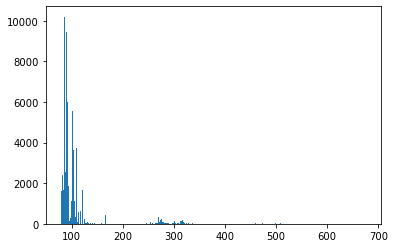

In [399]:
plt.bar(riskHigh['risk_score'].value_counts().index, riskHigh['risk_score'].value_counts().values)

<BarContainer object of 180 artists>

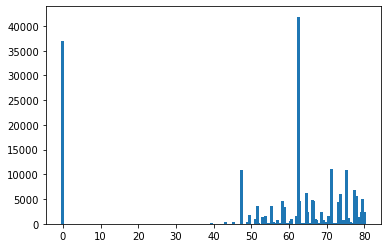

In [400]:
plt.bar(riskLow['risk_score'].value_counts().index, riskLow['risk_score'].value_counts().values)

### risk score切分落在124左右(original)

In [401]:
riskHighID = riskHigh['alert_id'].values

In [402]:
riskLowID = riskLow['alert_id'].values

# 分群閥值

In [403]:
%run ./function.ipynb

In [404]:
SAR_type = 'TO_SAR'

## TWN_A11_01

In [405]:
DAY = 15
FEATURE = ['Credit_Amt', 'number_of_Credit', 'Debit_Amt', 'number_of_Debit']
PATH = "D:/Temp/NCTU/crystal/第二階段/new_alert/日數分類_營業日/"
FILE = "TWN_A11_01_day15_with_aggregated_txn_scenario_txn_type_key_營業日.csv"

In [406]:
file = pd.read_csv(PATH+FILE)

In [407]:
file['TO_SAR'] = file['TO_SAR'].replace(np.nan, 0)
file['TO_SAR'] = file['TO_SAR'].replace('NF', 1)
file['TO_SAR'] = file['TO_SAR'].replace('F', 1)

In [408]:
file['TO_SAR'].value_counts()

0    86324
1      446
Name: TO_SAR, dtype: int64

In [409]:
file.shape

(86770, 45)

In [410]:
fileID = file['alert_id'].values

In [411]:
HighIntersection = list(set(fileID) & set(riskHighID))

In [412]:
rowHigh = []
rowLow = []
for i in range(file.shape[0]):
    if file['alert_id'][i] in HighIntersection:
        rowHigh.append(i)
    else:
        rowLow.append(i)

In [413]:
file1 = file.iloc[rowHigh] 

In [414]:
file1['TO_SAR'].value_counts()

0    40135
1      188
Name: TO_SAR, dtype: int64

In [415]:
train_set, test_set = ReadFile(file1, SAR_type)

Verify on time series
shape of data: (40323, 39)
total number of TO_SAR: 188
********************************
time interval in train set:2019-03-04~2020-02-18
TO_SAR in train set: 112
TO_SAR/Total in train set 0.004629438267267391
split dataset to train, test...
********************************
time interval in test set:2020-02-18~2020-12-31
TO_SAR in test set: 76
TO_SAR/Total in test set 0.004711717296962182
********************************
train data shape:  (24193, 38)
test data shape:  (16130, 38)


In [416]:
train_SAR = train_set[train_set['TO_SAR']!=0]
train_Non_SAR = train_set[train_set['TO_SAR']==0]

In [417]:
test_SAR = test_set[test_set['TO_SAR']!=0]
test_Non_SAR = test_set[test_set['TO_SAR']==0]

### Search Answer

In [418]:
number_of_credit_threshold = []
credit_amt_threshold = []
number_of_debit_threshold = []
debit_amt_threshold = []
threshold_list = [credit_amt_threshold, number_of_credit_threshold, debit_amt_threshold, number_of_debit_threshold]

for i in range(len(FEATURE)):
    tmp = []
    tmp = list(train_SAR[FEATURE[i]].values)
    tmp.sort()
    for j in np.linspace(10, 100, 10):
        threshold_list[i].append(np.percentile(tmp, j))
    print(threshold_list[i])
    print()

[0.0, 0.0, 0.0, 0.0, 0.0, 207999.9999999987, 957999.9999999995, 1300800.0, 2196200.000000001, 6840000.0]

[0.0, 0.0, 0.0, 0.0, 0.0, 3.5999999999999943, 6.699999999999989, 13.0, 16.900000000000006, 31.0]

[0.0, 80005.0, 774110.9999999998, 984378.0, 1050000.0, 1131340.0, 1200000.0, 1354800.0, 1488618.0, 10550015.0]

[0.0, 1.0, 7.299999999999997, 10.0, 12.0, 15.0, 17.69999999999999, 20.0, 38.80000000000001, 100.0]



In [419]:
LOGIC = "OR"
default_number_of_credit = 5
default_credit_amt = 985500
candidate_rule1 = Search2D(number_of_credit_threshold, credit_amt_threshold, 'number_of_Credit','Credit_Amt',\
                           default_number_of_credit, default_credit_amt, train_SAR, train_Non_SAR, train_set, LOGIC, SAR_type)

max val:  0.21049704006567482 number of max val:  1
67th, recall: 0.17857142857142858, val1: 6.699999999999989, val2: 1300800.0
77th, recall: 0.14285714285714285, val1: 13.0, val2: 1300800.0
68th, recall: 0.08928571428571429, val1: 6.699999999999989, val2: 2196200.000000001
78th, recall: 0.05357142857142857, val1: 13.0, val2: 2196200.000000001
87th, recall: 0.05357142857142857, val1: 16.900000000000006, val2: 1300800.0
79th, recall: 0.026785714285714284, val1: 13.0, val2: 6840000.0
69th, recall: 0.026785714285714284, val1: 6.699999999999989, val2: 6840000.0
88th, recall: 0.026785714285714284, val1: 16.900000000000006, val2: 2196200.000000001
98th, recall: 0.008928571428571428, val1: 31.0, val2: 2196200.000000001
97th, recall: 0.008928571428571428, val1: 31.0, val2: 1300800.0
********************************


In [420]:
LOGIC = "OR"
default_number_of_debit = 5
default_debit_amt = 985500
candidate_rule2 = Search2D(debit_amt_threshold, number_of_debit_threshold, 'Debit_Amt','number_of_Debit',\
                           default_debit_amt,default_number_of_debit,  train_SAR, train_Non_SAR, train_set, LOGIC, SAR_type)

max val:  0.5130253269170201 number of max val:  1
42th, recall: 0.48214285714285715, val1: 1050000.0, val2: 7.299999999999997
43th, recall: 0.4107142857142857, val1: 1050000.0, val2: 10.0
44th, recall: 0.38392857142857145, val1: 1050000.0, val2: 12.0
52th, recall: 0.375, val1: 1131340.0, val2: 7.299999999999997
62th, recall: 0.33035714285714285, val1: 1200000.0, val2: 7.299999999999997
45th, recall: 0.30357142857142855, val1: 1050000.0, val2: 15.0
53th, recall: 0.30357142857142855, val1: 1131340.0, val2: 10.0
54th, recall: 0.2857142857142857, val1: 1131340.0, val2: 12.0
63th, recall: 0.25892857142857145, val1: 1200000.0, val2: 10.0
64th, recall: 0.24107142857142858, val1: 1200000.0, val2: 12.0
********************************


In [421]:
candidate_rule1 = [[ceil(x), ceil(y)] for [x,y] in candidate_rule1]
candidate_rule2 = [[ceil(x), ceil(y)] for [x,y] in candidate_rule2]

In [424]:
# apply on testing set
results = pd.DataFrame(columns = ['number_of_Credit','Credit_Amt',\
                                  'Debit_Amt','number_of_Debit','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
for thre1, thre2 in candidate_rule1:
    for thre3, thre4 in candidate_rule2:
       
        idx = list(set(test_set[test_set['number_of_Credit']>=thre1].index) & set(test_set[test_set['Credit_Amt']>=thre2].index))
        idx1 = list(set(test_set[test_set['Debit_Amt']>=thre3].index) & set(test_set[test_set['number_of_Debit']>=thre4].index))
        new_SAM_1_rule1 = test_set.iloc[idx]
        new_SAM_1_rule2 = test_set.iloc[idx1]

        new_SAM_1 = new_SAM_1_rule1.append(new_SAM_1_rule2)
        new_SAM_1 = new_SAM_1.drop_duplicates()
        new_SAM_0 = test_set.drop(index = new_SAM_1.index)

        if (new_SAM_0.shape[0]+new_SAM_1.shape[0])!=test_set.shape[0]:
            raise ValueError("new SAM 0 and new SAM 1 overlapped!")
            
        TP = new_SAM_1[new_SAM_1['TO_SAR']!=0].shape[0]
        TN = new_SAM_0[new_SAM_0['TO_SAR']==0].shape[0]
        FP = new_SAM_1[new_SAM_1['TO_SAR']==0].shape[0]
        FN = new_SAM_0[new_SAM_0['TO_SAR']!=0].shape[0]
        total = test_set.shape[0]
        results = results.append({'number_of_Credit':int(thre1),'Credit_Amt':thre2,  \
                                  'Debit_Amt':thre3, 'number_of_Debit':thre4, 'SAR':test_set[test_set['TO_SAR']!=0].shape[0], \
                                  'Non SAR':test_set[test_set['TO_SAR']==0].shape[0],\
                                  'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                                  'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                                  'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)


In [425]:
results = results.sort_values(by='recall', ascending=False)[:10].drop_duplicates()
results

,number_of_Credit,Credit_Amt,Debit_Amt,number_of_Debit,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
99,7,1300800,1050000,8,76,16054,51,8460,25,7594,0.6711,0.4723
96,7,1300800,1131340,8,76,16054,45,7825,31,8229,0.5921,0.5121
98,7,1300800,1050000,10,76,16054,44,7934,32,8120,0.5789,0.5054
89,13,1300800,1050000,8,76,16054,44,7093,32,8961,0.5789,0.5575
59,17,1300800,1050000,8,76,16054,42,6146,34,9908,0.5526,0.6164
95,7,1300800,1200000,8,76,16054,41,7415,35,8639,0.5395,0.5378
79,7,2196201,1050000,8,76,16054,41,5999,35,10055,0.5395,0.6255
9,31,1300800,1050000,8,76,16054,41,5050,35,11004,0.5395,0.6844
29,17,2196201,1050000,8,76,16054,40,5128,36,10926,0.5263,0.6796
69,13,2196201,1050000,8,76,16054,40,5510,36,10544,0.5263,0.6559


In [426]:
file2 = file.iloc[rowLow] 

In [427]:
train_set, test_set = ReadFile(file2, SAR_type)

Verify on time series
shape of data: (46447, 39)
total number of TO_SAR: 258
********************************
time interval in train set:2019-03-04~2020-05-12
TO_SAR in train set: 154
TO_SAR/Total in train set 0.00552624968600854
split dataset to train, test...
********************************
time interval in test set:2020-02-19~2020-12-31
TO_SAR in test set: 104
TO_SAR/Total in test set 0.005597416576964478
********************************
train data shape:  (27867, 38)
test data shape:  (18580, 38)


In [428]:
train_SAR = train_set[train_set['TO_SAR']!=0]
train_Non_SAR = train_set[train_set['TO_SAR']==0]

In [429]:
test_SAR = test_set[test_set['TO_SAR']!=0]
test_Non_SAR = test_set[test_set['TO_SAR']==0]

### Search Answer

In [430]:
number_of_credit_threshold = []
credit_amt_threshold = []
number_of_debit_threshold = []
debit_amt_threshold = []
threshold_list = [credit_amt_threshold, number_of_credit_threshold, debit_amt_threshold, number_of_debit_threshold]

for i in range(len(FEATURE)):
    tmp = []
    tmp = list(train_SAR[FEATURE[i]].values)
    tmp.sort()
    for j in np.linspace(10, 100, 10):
        threshold_list[i].append(np.percentile(tmp, j))
    print(threshold_list[i])
    print()

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 408199.99999999953, 1007024.8000000003, 1257820.0000000007, 6785000.0]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 7.0, 17.400000000000034, 98.0]

[1300.0000000000007, 845187.0, 1026414.0, 1116627.2, 1200117.5, 1466008.0, 1832009.0, 2196181.0, 2625000.000000001, 10600030.0]

[1.0, 5.0, 6.899999999999999, 11.0, 16.0, 19.0, 22.0, 29.400000000000006, 40.10000000000005, 149.0]



In [431]:
LOGIC = "OR"
default_number_of_credit = 5
default_credit_amt = 985500
candidate_rule1 = Search2D(number_of_credit_threshold, credit_amt_threshold, 'number_of_Credit','Credit_Amt',\
                           default_number_of_credit, default_credit_amt, train_SAR, train_Non_SAR, train_set, LOGIC, SAR_type)

max val:  0.19911493037960762 number of max val:  1
77th, recall: 0.16883116883116883, val1: 7.0, val2: 1007024.8000000003
87th, recall: 0.09090909090909091, val1: 17.400000000000034, val2: 1007024.8000000003
78th, recall: 0.07792207792207792, val1: 7.0, val2: 1257820.0000000007
88th, recall: 0.05194805194805195, val1: 17.400000000000034, val2: 1257820.0000000007
79th, recall: 0.006493506493506494, val1: 7.0, val2: 6785000.0
98th, recall: 0.006493506493506494, val1: 98.0, val2: 1257820.0000000007
97th, recall: 0.006493506493506494, val1: 98.0, val2: 1007024.8000000003
********************************


In [432]:
LOGIC = "OR"
default_number_of_debit = 5
default_debit_amt = 985500
candidate_rule2 = Search2D(debit_amt_threshold, number_of_debit_threshold, 'Debit_Amt','number_of_Debit',\
                           default_debit_amt, default_number_of_debit, train_SAR, train_Non_SAR, train_set, LOGIC, SAR_type)

max val:  0.6657805921739401 number of max val:  1
21th, recall: 0.6948051948051948, val1: 1026414.0, val2: 5.0
31th, recall: 0.5909090909090909, val1: 1116627.2, val2: 5.0
22th, recall: 0.5714285714285714, val1: 1026414.0, val2: 6.899999999999999
23th, recall: 0.5064935064935064, val1: 1026414.0, val2: 11.0
41th, recall: 0.4935064935064935, val1: 1200117.5, val2: 5.0
32th, recall: 0.4805194805194805, val1: 1116627.2, val2: 6.899999999999999
24th, recall: 0.43506493506493504, val1: 1026414.0, val2: 16.0
33th, recall: 0.43506493506493504, val1: 1116627.2, val2: 11.0
51th, recall: 0.3961038961038961, val1: 1466008.0, val2: 5.0
34th, recall: 0.38311688311688313, val1: 1116627.2, val2: 16.0
********************************


In [433]:
candidate_rule1 = [[ceil(x), ceil(y)] for [x,y] in candidate_rule1]
candidate_rule2 = [[ceil(x), ceil(y)] for [x,y] in candidate_rule2]

In [434]:
# apply on testing set
results = pd.DataFrame(columns = ['number_of_Credit','Credit_Amt',\
                                  'Debit_Amt','number_of_Debit','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
for thre1, thre2 in candidate_rule1:
    for thre3, thre4 in candidate_rule2:
       
        idx = list(set(test_set[test_set['number_of_Credit']>=thre1].index) & set(test_set[test_set['Credit_Amt']>=thre2].index))
        idx1 = list(set(test_set[test_set['Debit_Amt']>=thre3].index) & set(test_set[test_set['number_of_Debit']>=thre4].index))
        new_SAM_1_rule1 = test_set.iloc[idx]
        new_SAM_1_rule2 = test_set.iloc[idx1]

        new_SAM_1 = new_SAM_1_rule1.append(new_SAM_1_rule2)
        new_SAM_1 = new_SAM_1.drop_duplicates()
        new_SAM_0 = test_set.drop(index = new_SAM_1.index)

        if (new_SAM_0.shape[0]+new_SAM_1.shape[0])!=test_set.shape[0]:
            raise ValueError("new SAM 0 and new SAM 1 overlapped!")
            
        TP = new_SAM_1[new_SAM_1['TO_SAR']!=0].shape[0]
        TN = new_SAM_0[new_SAM_0['TO_SAR']==0].shape[0]
        FP = new_SAM_1[new_SAM_1['TO_SAR']==0].shape[0]
        FN = new_SAM_0[new_SAM_0['TO_SAR']!=0].shape[0]
        total = test_set.shape[0]
        results = results.append({'number_of_Credit':int(thre1),'Credit_Amt':thre2,  \
                                  'Debit_Amt':thre3, 'number_of_Debit':thre4, 'SAR':test_set[test_set['TO_SAR']!=0].shape[0], \
                                  'Non SAR':test_set[test_set['TO_SAR']==0].shape[0],\
                                  'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                                  'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                                  'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)


In [435]:
results = results.sort_values(by='recall', ascending=False)[:10].drop_duplicates()
results

,number_of_Credit,Credit_Amt,Debit_Amt,number_of_Debit,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
69,7,1007025,1026414,5,104,18476,82,12771,22,5705,0.7885,0.3082
49,7,1257821,1026414,5,104,18476,81,11197,23,7279,0.7788,0.393
39,18,1257821,1026414,5,104,18476,78,9094,26,9382,0.75,0.5064
59,18,1007025,1026414,5,104,18476,78,9457,26,9019,0.75,0.4868
68,7,1007025,1116628,5,104,18476,74,11520,30,6956,0.7115,0.376
9,98,1007025,1026414,5,104,18476,74,7718,30,10758,0.7115,0.5806
29,7,6785000,1026414,5,104,18476,74,7558,30,10918,0.7115,0.5892
19,98,1257821,1026414,5,104,18476,74,7708,30,10768,0.7115,0.5812
48,7,1257821,1116628,5,104,18476,73,9938,31,8538,0.7019,0.4612
67,7,1007025,1026414,7,104,18476,71,11195,33,7281,0.6827,0.3936


## TWN_A12_01

In [436]:
DAY = 15
FEATURE = ['Credit_Amt', 'number_of_Credit', 'Debit_Amt','number_of_Debit']
PATH = "D:/Temp/NCTU/crystal/第二階段/new_alert/日數分類_營業日/"
FILE = "TWN_A12_01_day15_with_aggregated_txn_scenario_txn_type_key_營業日.csv"

In [437]:
file = pd.read_csv(PATH+FILE)

C:\Users\NCTUUser2\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [438]:
file['TO_SAR'] = file['TO_SAR'].replace(np.nan, 0)
file['TO_SAR'] = file['TO_SAR'].replace('NF', 1)
file['TO_SAR'] = file['TO_SAR'].replace('F', 1)

In [439]:
file['TO_SAR'].value_counts()

0    49724
1      241
Name: TO_SAR, dtype: int64

In [440]:
fileID = file['alert_id'].values

In [441]:
HighIntersection = list(set(fileID) & set(riskHighID))

In [442]:
rowHigh = []
rowLow = []
for i in range(file.shape[0]):
    if file['alert_id'][i] in HighIntersection:
        rowHigh.append(i)
    else:
        rowLow.append(i)

In [443]:
file1 = file.iloc[rowHigh]

In [444]:
file1['TO_SAR'].value_counts()

0    24032
1      102
Name: TO_SAR, dtype: int64

In [445]:
train_set, test_set = ReadFile(file1, SAR_type)

Verify on time series
shape of data: (24134, 39)
total number of TO_SAR: 102
********************************
time interval in train set:2019-03-04~2020-06-11
TO_SAR in train set: 61
TO_SAR/Total in train set 0.004212707182320442
split dataset to train, test...
********************************
time interval in test set:2020-02-21~2020-12-31
TO_SAR in test set: 41
TO_SAR/Total in test set 0.004246944271804433
********************************
train data shape:  (14480, 38)
test data shape:  (9654, 38)


In [446]:
train_SAR = train_set[train_set['TO_SAR']!=0]
train_Non_SAR = train_set[train_set['TO_SAR']==0]

In [447]:
test_SAR = test_set[test_set['TO_SAR']!=0]
test_Non_SAR = test_set[test_set['TO_SAR']==0]

### Search Answer

In [448]:
number_of_credit_threshold = []
credit_amt_threshold = []
number_of_debit_threshold = []
debit_amt_threshold = []
threshold_list = [credit_amt_threshold, number_of_credit_threshold, debit_amt_threshold, number_of_debit_threshold]
for i in range(len(FEATURE)):
    tmp = []
    tmp = list(train_SAR[FEATURE[i]].values)
    tmp.sort()
    for j in np.linspace(10, 100, 10):
        threshold_list[i].append(np.percentile(tmp, j))
    print(threshold_list[i])
    print()

[0.0, 0.0, 0.0, 0.0, 20000.0, 1376000.0, 1750000.0, 2380514.0, 5108000.0, 14459232.0]

[0.0, 0.0, 0.0, 0.0, 1.0, 7.0, 12.0, 14.0, 24.0, 66.0]

[0.0, 42000.0, 110000.0, 956035.0, 1200000.0, 1356645.0, 1390000.0, 1966655.0, 2318790.0, 10550015.0]

[0.0, 1.0, 2.0, 7.0, 9.0, 11.0, 15.0, 18.0, 21.0, 41.0]



In [449]:
LOGIC='OR'
default_number_of_credit = 6
default_credit_amt = 1311700
candidate_rule1 = Search2D(number_of_credit_threshold, credit_amt_threshold, 'number_of_Credit','Credit_Amt',\
                           default_number_of_credit, default_credit_amt, train_SAR, train_Non_SAR, train_set, LOGIC, SAR_type)

max val:  0.37255839456661666 number of max val:  1
55th, recall: 0.3442622950819672, val1: 7.0, val2: 1376000.0
65th, recall: 0.2786885245901639, val1: 12.0, val2: 1376000.0
56th, recall: 0.2459016393442623, val1: 7.0, val2: 1750000.0
66th, recall: 0.19672131147540983, val1: 12.0, val2: 1750000.0
75th, recall: 0.19672131147540983, val1: 14.0, val2: 1376000.0
57th, recall: 0.18032786885245902, val1: 7.0, val2: 2380514.0
76th, recall: 0.16393442622950818, val1: 14.0, val2: 1750000.0
67th, recall: 0.14754098360655737, val1: 12.0, val2: 2380514.0
77th, recall: 0.11475409836065574, val1: 14.0, val2: 2380514.0
86th, recall: 0.09836065573770492, val1: 24.0, val2: 1750000.0
********************************


In [450]:
LOGIC='OR'
default_number_of_debit = 6
default_debit_amt = 1311700
candidate_rule2 = Search2D(number_of_debit_threshold, debit_amt_threshold, 'number_of_Debit', 'Debit_Amt',\
                           default_number_of_debit, default_debit_amt, train_SAR, train_Non_SAR, train_set, LOGIC, SAR_type)

max val:  0.41211331730232525 number of max val:  1
35th, recall: 0.3770491803278688, val1: 7.0, val2: 1356645.0
36th, recall: 0.32786885245901637, val1: 7.0, val2: 1390000.0
45th, recall: 0.29508196721311475, val1: 9.0, val2: 1356645.0
46th, recall: 0.2459016393442623, val1: 9.0, val2: 1390000.0
37th, recall: 0.19672131147540983, val1: 7.0, val2: 1966655.0
55th, recall: 0.19672131147540983, val1: 11.0, val2: 1356645.0
65th, recall: 0.18032786885245902, val1: 15.0, val2: 1356645.0
66th, recall: 0.14754098360655737, val1: 15.0, val2: 1390000.0
56th, recall: 0.14754098360655737, val1: 11.0, val2: 1390000.0
38th, recall: 0.11475409836065574, val1: 7.0, val2: 2318790.0
********************************


In [451]:
candidate_rule1 = [[ceil(x), ceil(y)] for [x,y] in candidate_rule1]
candidate_rule2 = [[ceil(x), ceil(y)] for [x,y] in candidate_rule2]

In [452]:
# apply on testing set
results = pd.DataFrame(columns = ['number_of_Credit','Credit_Amt',\
                                  'number_of_Debit','Debit_Amt','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
for thre1, thre2 in candidate_rule1:
    for thre3, thre4 in candidate_rule2:
       
        idx = list(set(test_set[test_set['number_of_Credit']>=thre1].index) & set(test_set[test_set['Credit_Amt']>=thre2].index))
        idx1 = list(set(test_set[test_set['number_of_Debit']>=thre3].index) & set(test_set[test_set['Debit_Amt']>=thre4].index))
        new_SAM_1_rule1 = test_set.iloc[idx]
        new_SAM_1_rule2 = test_set.iloc[idx1]

        new_SAM_1 = new_SAM_1_rule1.append(new_SAM_1_rule2)
        new_SAM_1 = new_SAM_1.drop_duplicates()
        new_SAM_0 = test_set.drop(index = new_SAM_1.index)

        if (new_SAM_0.shape[0]+new_SAM_1.shape[0])!=test_set.shape[0]:
            raise ValueError("new SAM 0 and new SAM 1 overlapped!")
            
        TP = new_SAM_1[new_SAM_1['TO_SAR']!=0].shape[0]
        TN = new_SAM_0[new_SAM_0['TO_SAR']==0].shape[0]
        FP = new_SAM_1[new_SAM_1['TO_SAR']==0].shape[0]
        FN = new_SAM_0[new_SAM_0['TO_SAR']!=0].shape[0]
        total = test_set.shape[0]
        results = results.append({'number_of_Credit':int(thre1),'Credit_Amt':thre2,  \
                                  'number_of_Debit':thre3, 'Debit_Amt':thre4, 'SAR':test_set[test_set['TO_SAR']!=0].shape[0], \
                                  'Non SAR':test_set[test_set['TO_SAR']==0].shape[0],\
                                  'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                                  'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                                  'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)


In [453]:
results = results.sort_values(by='recall', ascending=False).drop_duplicates()[:10]
results

,number_of_Credit,Credit_Amt,number_of_Debit,Debit_Amt,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
99,7,1376000,7,1356645,41,9613,33,7272,8,2341,0.8049,0.2433
98,7,1376000,7,1390000,41,9613,32,7156,9,2457,0.7805,0.2554
79,7,1750000,7,1356645,41,9613,30,5987,11,3626,0.7317,0.3767
78,7,1750000,7,1390000,41,9613,29,5867,12,3746,0.7073,0.3893
97,7,1376000,9,1356645,41,9613,28,6861,13,2752,0.6829,0.2864
69,12,1750000,7,1356645,41,9613,27,5153,14,4460,0.6585,0.4634
59,14,1376000,7,1356645,41,9613,27,5536,14,4077,0.6585,0.4238
96,7,1376000,9,1390000,41,9613,27,6764,14,2849,0.6585,0.2966
89,12,1376000,7,1356645,41,9613,27,5985,14,3628,0.6585,0.3773
39,14,1750000,7,1356645,41,9613,27,4828,14,4785,0.6585,0.4971


In [454]:
file2 = file.iloc[rowLow]

In [455]:
train_set, test_set = ReadFile(file2, SAR_type)

Verify on time series
shape of data: (25831, 39)
total number of TO_SAR: 139
********************************
time interval in train set:2019-03-04~2020-04-29
TO_SAR in train set: 83
TO_SAR/Total in train set 0.005355529745773648
split dataset to train, test...
********************************
time interval in test set:2020-02-19~2020-12-31
TO_SAR in test set: 56
TO_SAR/Total in test set 0.00541952966224717
********************************
train data shape:  (15498, 38)
test data shape:  (10333, 38)


In [456]:
train_SAR = train_set[train_set['TO_SAR']!=0]
train_Non_SAR = train_set[train_set['TO_SAR']==0]

In [457]:
test_SAR = test_set[test_set['TO_SAR']!=0]
test_Non_SAR = test_set[test_set['TO_SAR']==0]

In [458]:
number_of_credit_threshold = []
credit_amt_threshold = []
number_of_debit_threshold = []
debit_amt_threshold = []
threshold_list = [credit_amt_threshold, number_of_credit_threshold, debit_amt_threshold, number_of_debit_threshold]
for i in range(len(FEATURE)):
    tmp = []
    tmp = list(train_SAR[FEATURE[i]].values)
    tmp.sort()
    for j in np.linspace(10, 100, 10):
        threshold_list[i].append(np.percentile(tmp, j))
    print(threshold_list[i])
    print()

[0.0, 0.0, 0.0, 0.0, 0.0, 201778.9999999989, 798607.3999999997, 1400123.2000000002, 2019462.1999999993, 6785000.0]

[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3.0, 8.0, 24.0, 98.0]

[1200.0000000000011, 980707.0000000007, 1542000.0, 1770106.0000000005, 1950000.0, 2196911.0, 2481907.4, 2956040.0000000014, 3235804.0, 10600030.0]

[1.0, 6.0, 9.599999999999998, 14.0, 18.0, 23.199999999999996, 30.4, 42.0, 48.39999999999999, 149.0]



In [459]:
LOGIC='OR'
default_credit_amt = 1311700
default_number_of_credit = 6
candidate_rule1 = Search2D(number_of_credit_threshold, credit_amt_threshold, 'number_of_Credit','Credit_Amt',\
                           default_number_of_credit, default_credit_amt, train_SAR, train_Non_SAR, train_set, LOGIC, SAR_type)

max val:  0.17143283598591433 number of max val:  1
77th, recall: 0.14457831325301204, val1: 8.0, val2: 1400123.2000000002
78th, recall: 0.08433734939759036, val1: 8.0, val2: 2019462.1999999993
87th, recall: 0.07228915662650602, val1: 24.0, val2: 1400123.2000000002
88th, recall: 0.04819277108433735, val1: 24.0, val2: 2019462.1999999993
79th, recall: 0.012048192771084338, val1: 8.0, val2: 6785000.0
98th, recall: 0.012048192771084338, val1: 98.0, val2: 2019462.1999999993
97th, recall: 0.012048192771084338, val1: 98.0, val2: 1400123.2000000002
********************************


In [460]:
LOGIC = 'OR'
default_debit_amt = 1311700
default_number_of_debit = 6
candidate_rule2 = Search2D(number_of_debit_threshold, debit_amt_threshold, 'number_of_Debit','Debit_Amt', \
                           default_number_of_debit, default_debit_amt, train_SAR, train_Non_SAR, train_set, LOGIC, SAR_type)

max val:  0.696983743887547 number of max val:  1
12th, recall: 0.6987951807228916, val1: 6.0, val2: 1542000.0
13th, recall: 0.6024096385542169, val1: 6.0, val2: 1770106.0000000005
22th, recall: 0.5542168674698795, val1: 9.599999999999998, val2: 1542000.0
14th, recall: 0.5060240963855421, val1: 6.0, val2: 1950000.0
32th, recall: 0.4939759036144578, val1: 14.0, val2: 1542000.0
23th, recall: 0.4819277108433735, val1: 9.599999999999998, val2: 1770106.0000000005
42th, recall: 0.4457831325301205, val1: 18.0, val2: 1542000.0
33th, recall: 0.42168674698795183, val1: 14.0, val2: 1770106.0000000005
15th, recall: 0.39759036144578314, val1: 6.0, val2: 2196911.0
43th, recall: 0.3855421686746988, val1: 18.0, val2: 1770106.0000000005
********************************


In [461]:
candidate_rule1 = [[ceil(x), ceil(y)] for [x,y] in candidate_rule1]
candidate_rule2 = [[ceil(x), ceil(y)] for [x,y] in candidate_rule2]

In [462]:
# apply on testing set
results = pd.DataFrame(columns = ['number_of_Credit','Credit_Amt',\
                                  'number_of_Debit','Debit_Amt','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
for thre1, thre2 in candidate_rule1:
    for thre3, thre4 in candidate_rule2:
       
        idx = list(set(test_set[test_set['number_of_Credit']>=thre1].index) & set(test_set[test_set['Credit_Amt']>=thre2].index))
        idx1 = list(set(test_set[test_set['number_of_Debit']>=thre3].index) & set(test_set[test_set['Debit_Amt']>=thre4].index))
        new_SAM_1_rule1 = test_set.iloc[idx]
        new_SAM_1_rule2 = test_set.iloc[idx1]

        new_SAM_1 = new_SAM_1_rule1.append(new_SAM_1_rule2)
        new_SAM_1 = new_SAM_1.drop_duplicates()
        new_SAM_0 = test_set.drop(index = new_SAM_1.index)

        if (new_SAM_0.shape[0]+new_SAM_1.shape[0])!=test_set.shape[0]:
            raise ValueError("new SAM 0 and new SAM 1 overlapped!")
            
        TP = new_SAM_1[new_SAM_1['TO_SAR']!=0].shape[0]
        TN = new_SAM_0[new_SAM_0['TO_SAR']==0].shape[0]
        FP = new_SAM_1[new_SAM_1['TO_SAR']==0].shape[0]
        FN = new_SAM_0[new_SAM_0['TO_SAR']!=0].shape[0]
        total = test_set.shape[0]
        results = results.append({'number_of_Credit':int(thre1),'Credit_Amt':thre2,  \
                                  'number_of_Debit':thre3, 'Debit_Amt':thre4, 'SAR':test_set[test_set['TO_SAR']!=0].shape[0], \
                                  'Non SAR':test_set[test_set['TO_SAR']==0].shape[0],\
                                  'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                                  'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                                  'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)


In [463]:
results = results.sort_values(by='recall', ascending=False).drop_duplicates()[:10]
results

,number_of_Credit,Credit_Amt,number_of_Debit,Debit_Amt,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
69,8,1400124,6,1542000,56,10277,36,6363,20,3914,0.6429,0.3807
59,8,2019463,6,1542000,56,10277,35,4989,21,5288,0.625,0.5138
49,24,1400124,6,1542000,56,10277,33,4050,23,6227,0.5893,0.6049
39,24,2019463,6,1542000,56,10277,33,3692,23,6585,0.5893,0.6395
29,8,6785000,6,1542000,56,10277,33,2921,23,7356,0.5893,0.7141
9,98,1400124,6,1542000,56,10277,33,3042,23,7235,0.5893,0.7024
68,8,1400124,6,1770107,56,10277,33,5591,23,4686,0.5893,0.4557
19,98,2019463,6,1542000,56,10277,33,2906,23,7371,0.5893,0.7156
58,8,2019463,6,1770107,56,10277,32,4207,24,6070,0.5714,0.5898
66,8,1400124,6,1950000,56,10277,30,5207,26,5070,0.5357,0.4932


## TWN_A13_01

In [464]:
DAY = 15
FEATURE = ['Credit_Amt', 'number_of_Credit', 'Debit_Amt','number_of_Debit']
PATH = "D:/Temp/NCTU/crystal/第二階段/new_alert/日數分類_營業日/"
FILE = "TWN_A13_01_day15_with_aggregated_txn_scenario_txn_type_key_營業日.csv"

In [465]:
file = pd.read_csv(PATH+FILE)

In [466]:
file['TO_SAR'] = file['TO_SAR'].replace(np.nan, 0)
file['TO_SAR'] = file['TO_SAR'].replace('NF', 1)
file['TO_SAR'] = file['TO_SAR'].replace('F', 1)

In [467]:
fileID = file['alert_id'].values

In [468]:
HighIntersection = list(set(fileID) & set(riskHighID))

In [469]:
rowHigh = []
rowLow = []
for i in range(file.shape[0]):
    if file['alert_id'][i] in HighIntersection:
        rowHigh.append(i)
    else:
        rowLow.append(i)

In [483]:
file2 = file.iloc[rowLow] 

In [484]:
file2['TO_SAR'].value_counts()

0    5159
1      37
Name: TO_SAR, dtype: int64

In [485]:
train_set, test_set = ReadFile(file2, SAR_type)

Verify on time series
shape of data: (5196, 39)
total number of TO_SAR: 37
********************************
time interval in train set:2019-03-04~2020-05-11
TO_SAR in train set: 22
TO_SAR/Total in train set 0.007058068655758742
split dataset to train, test...
********************************
time interval in test set:2020-04-17~2020-12-31
TO_SAR in test set: 15
TO_SAR/Total in test set 0.007215007215007215
********************************
train data shape:  (3117, 38)
test data shape:  (2079, 38)


In [486]:
train_SAR = train_set[train_set['TO_SAR']!=0]
train_Non_SAR = train_set[train_set['TO_SAR']==0]

In [487]:
test_SAR = test_set[test_set['TO_SAR']!=0]
test_Non_SAR = test_set[test_set['TO_SAR']==0]

### Search Answer

In [488]:
number_of_credit_threshold = []
credit_amt_threshold = []
number_of_debit_threshold = []
debit_amt_threshold = []
threshold_list = [credit_amt_threshold, number_of_credit_threshold, debit_amt_threshold, number_of_debit_threshold]
for i in range(len(FEATURE)):
    tmp = []
    tmp = list(train_SAR[FEATURE[i]].values)
    tmp.sort()
    for j in np.linspace(10, 100, 10):
        threshold_list[i].append(np.percentile(tmp, j))
    print(threshold_list[i])
    print()

[0.0, 0.0, 0.0, 0.0, 0.0, 541199.9999999997, 1215599.9999999998, 1516087.2000000002, 1695000.0000000002, 3913000.0]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.5999999999999996, 3.0, 3.0, 5.800000000000004, 8.0]

[0.0, 116578.80000000002, 1350000.0, 1452006.0, 1800000.0, 2140500.0, 2340000.0, 2755900.0, 3227400.0000000005, 6421000.0]

[0.0, 1.4000000000000004, 3.0, 4.4, 5.0, 6.0, 7.0, 8.600000000000001, 27.500000000000032, 36.0]



In [489]:
LOGIC = 'OR'
default_credit_amt = 999995
default_number_of_credit = 3
candidate_rule1 = Search2D(number_of_credit_threshold, credit_amt_threshold, 'number_of_Credit','Credit_Amt',\
                           default_number_of_credit, default_credit_amt, train_SAR, train_Non_SAR, train_set, LOGIC, SAR_type)

max val:  0.30215538725245866 number of max val:  2
66th, recall: 0.2727272727272727, val1: 3.0, val2: 1215599.9999999998
76th, recall: 0.2727272727272727, val1: 3.0, val2: 1215599.9999999998
67th, recall: 0.18181818181818182, val1: 3.0, val2: 1516087.2000000002
77th, recall: 0.18181818181818182, val1: 3.0, val2: 1516087.2000000002
87th, recall: 0.13636363636363635, val1: 5.800000000000004, val2: 1516087.2000000002
86th, recall: 0.13636363636363635, val1: 5.800000000000004, val2: 1215599.9999999998
68th, recall: 0.13636363636363635, val1: 3.0, val2: 1695000.0000000002
78th, recall: 0.13636363636363635, val1: 3.0, val2: 1695000.0000000002
88th, recall: 0.09090909090909091, val1: 5.800000000000004, val2: 1695000.0000000002
99th, recall: 0.045454545454545456, val1: 8.0, val2: 3913000.0
********************************


In [490]:
LOGIC='OR'
default_debit_amt = 999995
default_number_of_debit = 3
candidate_rule2 = Search2D(number_of_debit_threshold, debit_amt_threshold, 'number_of_Debit','Debit_Amt', \
                           default_number_of_debit, default_debit_amt, train_SAR, train_Non_SAR, train_set, LOGIC, SAR_type)

max val:  0.6986072423398331 number of max val:  1
22th, recall: 0.7272727272727273, val1: 3.0, val2: 1350000.0
23th, recall: 0.5909090909090909, val1: 3.0, val2: 1452006.0
33th, recall: 0.5454545454545454, val1: 4.4, val2: 1452006.0
43th, recall: 0.5454545454545454, val1: 5.0, val2: 1452006.0
32th, recall: 0.5454545454545454, val1: 4.4, val2: 1350000.0
42th, recall: 0.5454545454545454, val1: 5.0, val2: 1350000.0
34th, recall: 0.5, val1: 4.4, val2: 1800000.0
44th, recall: 0.5, val1: 5.0, val2: 1800000.0
24th, recall: 0.5, val1: 3.0, val2: 1800000.0
35th, recall: 0.4090909090909091, val1: 4.4, val2: 2140500.0
********************************


In [491]:
candidate_rule1 = [[ceil(x), ceil(y)] for [x,y] in candidate_rule1]
candidate_rule2 = [[ceil(x), ceil(y)] for [x,y] in candidate_rule2]

In [492]:
# apply on testing set
results = pd.DataFrame(columns = ['number_of_Credit','Credit_Amt',\
                                  'number_of_Debit','Debit_Amt','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
for thre1, thre2 in candidate_rule1:
    for thre3, thre4 in candidate_rule2:
       
        idx = list(set(test_set[test_set['number_of_Credit']>=thre1].index) & set(test_set[test_set['Credit_Amt']>=thre2].index))
        idx1 = list(set(test_set[test_set['number_of_Debit']>=thre3].index) & set(test_set[test_set['Debit_Amt']>=thre4].index))
        new_SAM_1_rule1 = test_set.iloc[idx]
        new_SAM_1_rule2 = test_set.iloc[idx1]

        new_SAM_1 = new_SAM_1_rule1.append(new_SAM_1_rule2)
        new_SAM_1 = new_SAM_1.drop_duplicates()
        new_SAM_0 = test_set.drop(index = new_SAM_1.index)

        if (new_SAM_0.shape[0]+new_SAM_1.shape[0])!=test_set.shape[0]:
            raise ValueError("new SAM 0 and new SAM 1 overlapped!")
            
        TP = new_SAM_1[new_SAM_1['TO_SAR']!=0].shape[0]
        TN = new_SAM_0[new_SAM_0['TO_SAR']==0].shape[0]
        FP = new_SAM_1[new_SAM_1['TO_SAR']==0].shape[0]
        FN = new_SAM_0[new_SAM_0['TO_SAR']!=0].shape[0]
        total = test_set.shape[0]
        results = results.append({'number_of_Credit':int(thre1),'Credit_Amt':thre2,  \
                                  'number_of_Debit':thre3, 'Debit_Amt':thre4, 'SAR':test_set[test_set['TO_SAR']!=0].shape[0], \
                                  'Non SAR':test_set[test_set['TO_SAR']==0].shape[0],\
                                  'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                                  'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                                  'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)


In [493]:
results = results.sort_values(by='recall', ascending=False).drop_duplicates()[:10]
results

,number_of_Credit,Credit_Amt,number_of_Debit,Debit_Amt,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
99,3,1215600,3,1350000,15,2064,14,1627,1,437,0.9333,0.2107
69,3,1516088,3,1350000,15,2064,14,1368,1,696,0.9333,0.3353
29,3,1695001,3,1350000,15,2064,13,1296,2,768,0.8667,0.3704
49,6,1215600,3,1350000,15,2064,12,1142,3,922,0.8,0.4449
9,8,3913000,3,1350000,15,2064,12,909,3,1155,0.8,0.557
59,6,1516088,3,1350000,15,2064,12,1141,3,923,0.8,0.4454
19,6,1695001,3,1350000,15,2064,12,1132,3,932,0.8,0.4497
91,3,1215600,3,1800000,15,2064,11,1326,4,738,0.7333,0.3569
71,3,1516088,3,1800000,15,2064,11,1067,4,997,0.7333,0.4815
68,3,1516088,3,1452006,15,2064,11,1214,4,850,0.7333,0.4108


## TWN_A15_01

In [494]:
DAY = [1, 5]
FEATURE = ['Credit_Amt', 'Debit_Amt_1Day', 'debit/credit']
PATH = "D:/Temp/NCTU/crystal/第二階段/new_alert/日數分類_營業日/"
FILE = "TWN_A15_01_with_aggregated_txn_scenario_txn_type_key_營業日.csv"

In [495]:
file = pd.read_csv(PATH+FILE)

In [496]:
file.shape

(12530, 44)

In [497]:
file['TO_SAR'] = file['TO_SAR'].replace(np.nan, 0)
file['TO_SAR'] = file['TO_SAR'].replace('NF', 1)
file['TO_SAR'] = file['TO_SAR'].replace('F', 1)

In [498]:
file['TO_SAR'].value_counts()

0    12505
1       25
Name: TO_SAR, dtype: int64

In [499]:
fileID = file['alert_id'].values

In [500]:
HighIntersection = list(set(fileID) & set(riskHighID))

In [501]:
rowHigh = []
rowLow = []
for i in range(file.shape[0]):
    if file['alert_id'][i] in HighIntersection:
        rowHigh.append(i)
    else:
        rowLow.append(i)

In [502]:
file1 = file.iloc[rowHigh]

In [503]:
file1['TO_SAR'].value_counts() 

0    1789
1       4
Name: TO_SAR, dtype: int64

In [513]:
file2 = file.iloc[rowLow]

In [514]:
train_set, test_set = ReadFile(file2, SAR_type)

Verify on time series
shape of data: (10737, 38)
total number of TO_SAR: 21
********************************
time interval in train set:2020-02-17~2020-12-11
TO_SAR in train set: 12
TO_SAR/Total in train set 0.0018630647414997672
split dataset to train, test...
********************************
time interval in test set:2020-08-31~2020-12-31
TO_SAR in test set: 9
TO_SAR/Total in test set 0.002094972067039106
********************************
train data shape:  (6441, 37)
test data shape:  (4296, 37)


In [515]:
train_SAR = train_set[train_set['TO_SAR']!=0]
train_Non_SAR = train_set[train_set['TO_SAR']==0]

In [516]:
test_SAR = test_set[test_set['TO_SAR']!=0]
test_Non_SAR = test_set[test_set['TO_SAR']==0]

### Search Answer

In [517]:
debit_amt_1day_threshold = []
credit_amt_threshold = []
ratio_threshold = []
threshold_list = [credit_amt_threshold, debit_amt_1day_threshold,  ratio_threshold]

for i in range(len(FEATURE)):
    tmp = []
    tmp = list(train_SAR[FEATURE[i]].values)
    tmp.sort()
    for j in np.linspace(10, 100, 10):
        threshold_list[i].append(np.percentile(tmp, j))
    print(threshold_list[i])
    print()

[925800.0, 1166400.0, 1244400.0, 1349744.0, 1521180.5, 1779424.4, 2212601.9999999995, 4074540.0000000014, 5850000.0, 39258714.0]

[719758.0, 918084.0, 1006683.5, 1073227.0, 1470005.0, 1916004.0, 2280000.0, 4080000.0000000014, 5850000.0, 39258714.0]

[0.855963344630015, 0.9772897881991744, 0.9946907426597582, 0.9990450247279921, 0.9999896142433233, 1.0, 1.0, 1.0, 1.5325195665564697, 2.0]



In [518]:
LOGIC = 'AND'
default_debit_amt_1Day = 387219
default_credit_amt = 387219
candidate_rule1 = Search2D(debit_amt_1day_threshold, credit_amt_threshold, 'Debit_Amt_1Day','Credit_Amt',\
                           default_debit_amt_1Day, default_credit_amt, train_SAR, train_Non_SAR, train_set, LOGIC, SAR_type)

max val:  0.75 number of max val:  2
0th, recall: 0.75, val1: 719758.0, val2: 925800.0
10th, recall: 0.75, val1: 918084.0, val2: 925800.0
1th, recall: 0.6666666666666666, val1: 719758.0, val2: 1166400.0
11th, recall: 0.6666666666666666, val1: 918084.0, val2: 1166400.0
20th, recall: 0.6666666666666666, val1: 1006683.5, val2: 925800.0
2th, recall: 0.5833333333333334, val1: 719758.0, val2: 1244400.0
12th, recall: 0.5833333333333334, val1: 918084.0, val2: 1244400.0
21th, recall: 0.5833333333333334, val1: 1006683.5, val2: 1166400.0
30th, recall: 0.5833333333333334, val1: 1073227.0, val2: 925800.0
3th, recall: 0.5, val1: 719758.0, val2: 1349744.0
********************************


In [519]:
LOGIC = 'AND'
default_ratio = 0.75
candidate_rule2 = Search1D(ratio_threshold, 'debit/credit', default_ratio, train_SAR, train_Non_SAR, train_set, LOGIC, SAR_type)

0.8333333333333334
0.75
0.6666666666666666
0.5833333333333334
0.5
0.5
0.5
0.5
0.16666666666666666
0.08333333333333333
recall [0.8333333333333334, 0.75, 0.6666666666666666, 0.5833333333333334, 0.5, 0.5, 0.5, 0.5, 0.16666666666666666, 0.08333333333333333, 0, 0, 0, 0, 0, 0, 0, 0, 0]
max val:  0.8333333333333334 number of max val:  1
number of zero: 9
0th, recall: 0.8333333333333334 , val: 0.855963344630015
1th, recall: 0.75 , val: 0.9772897881991744
2th, recall: 0.6666666666666666 , val: 0.9946907426597582
3th, recall: 0.5833333333333334 , val: 0.9990450247279921
4th, recall: 0.5 , val: 0.9999896142433233
5th, recall: 0.5 , val: 1.0
6th, recall: 0.5 , val: 1.0
7th, recall: 0.5 , val: 1.0
8th, recall: 0.16666666666666666 , val: 1.5325195665564697
9th, recall: 0.08333333333333333 , val: 2.0


In [520]:
candidate_rule1 = [[ceil(x), ceil(y)] for [x,y] in candidate_rule1]

In [521]:
# apply on testing set
results = pd.DataFrame(columns = ['Debit_Amt_1Day','Credit_Amt',\
                                  'debit/credit','SAR', 'Non SAR','newSAM=1_SAR=1(TP)','newSAM=1_SAR=0(FP)',\
                                  'newSAM=0_SAR=1(FN)', 'newSAM=0_SAR=0(TN)', 'recall','filter rate'])
for thre1, thre2 in candidate_rule1:
    for thre3 in candidate_rule2:
        idx1 = set(test_set[test_set['Debit_Amt_1Day']>=thre1].index) & set(test_set[test_set['Credit_Amt']>=thre2].index)
        idx2 = set(test_set[test_set['debit/credit']>=thre3].index)

        idx = list(idx1 &idx2)

        new_SAM_1_rule = test_set.iloc[idx]

        new_SAM_1 = new_SAM_1_rule
        new_SAM_0 = test_set.drop(index = new_SAM_1.index)

        if (new_SAM_0.shape[0]+new_SAM_1.shape[0])!=test_set.shape[0]:
            raise ValueError("new SAM 0 and new SAM 1 overlapped!")
        TP = new_SAM_1[new_SAM_1['TO_SAR']!=0].shape[0]
        TN = new_SAM_0[new_SAM_0['TO_SAR']==0].shape[0]
        FP = new_SAM_1[new_SAM_1['TO_SAR']==0].shape[0]
        FN = new_SAM_0[new_SAM_0['TO_SAR']!=0].shape[0]
        total = test_set.shape[0]
        results = results.append({'Debit_Amt_1Day':thre1,'Credit_Amt':thre2,  \
                                  'debit/credit':thre3, \
                                  'SAR':test_set[test_set['TO_SAR']!=0].shape[0], \
                                  'Non SAR':test_set[test_set['TO_SAR']==0].shape[0],\
                                  'newSAM=1_SAR=1(TP)':TP, 'newSAM=1_SAR=0(FP)':FP, 'newSAM=0_SAR=1(FN)':FN,\
                                  'newSAM=0_SAR=0(TN)':TN, 'recall': str(round(TP/(TP+FN), 4)),\
                                  'filter rate':str((round((TN+FN)/total, 4)))}, ignore_index = True)


In [522]:
results = results.sort_values(by='recall', ascending=False)[:10]
results

,Debit_Amt_1Day,Credit_Amt,debit/credit,SAR,Non SAR,newSAM=1_SAR=1(TP),newSAM=1_SAR=0(FP),newSAM=0_SAR=1(FN),newSAM=0_SAR=0(TN),recall,filter rate
99,719758,925800,0.855963,9,4287,8,2256,1,2031,0.8889,0.473
69,918084,1166400,0.855963,9,4287,8,1695,1,2592,0.8889,0.6036
29,1006684,1166400,0.855963,9,4287,8,1691,1,2596,0.8889,0.6045
79,719758,1166400,0.855963,9,4287,8,1695,1,2592,0.8889,0.6036
59,1006684,925800,0.855963,9,4287,8,1884,1,2403,0.8889,0.5596
49,719758,1244400,0.855963,9,4287,8,1641,1,2646,0.8889,0.6162
89,918084,925800,0.855963,9,4287,8,2224,1,2063,0.8889,0.4804
19,1073227,925800,0.855963,9,4287,8,1763,1,2524,0.8889,0.5878
9,719758,1349744,0.855963,9,4287,8,1583,1,2704,0.8889,0.6297
39,918084,1244400,0.855963,9,4287,8,1641,1,2646,0.8889,0.6162
